In [ ]:
# installing PyPortfolioOpt
!pip install pyportfolioopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#!pip install PyPortfolioOpt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA

In [ ]:
df=pd.read_excel('Historical prices CAC40.xlsx')
# Converting the 'Date' column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Calculating log returns
returns = df.pct_change().dropna().apply(lambda x: np.log(1 + x))
# Filling NaN values with mean return
returns = returns.fillna(returns.mean())

In [ ]:
# Compute variance for each stock
variances = returns.var()

# Compute standard deviation for each stock
monthly_standard_deviations = returns.std()

# Annualize the standard deviation
annualized_standard_deviations = monthly_standard_deviations * np.sqrt(12)

print("Variances:\n", variances)
print("\nMonthly Standard Deviations:\n", monthly_standard_deviations)
print("\nAnnualized Standard Deviations:\n", annualized_standard_deviations)


Variances:
 LVMH.PA     0.004027
OREP.PA     0.002576
HRMS.PA     0.004689
TTEF.PA     0.004771
SASY.PA     0.003131
AIR.PA      0.010252
SCHN.PA     0.004401
AIRP.PA     0.002571
ESLX.PA     0.003752
BNPP.PA     0.009726
PRTP.PA     0.006536
AXAF.PA     0.006837
SAF.PA      0.006670
SGEF.PA     0.003497
STLAM.PA    0.010739
DAST.PA     0.004238
PERP.PA     0.002647
STMPA.PA    0.010688
DANO.PA     0.002616
ENGIE.PA    0.005743
CAGR.PA     0.009732
SGOB.PA     0.006668
CAPP.PA     0.005189
TCFP.PA     0.005091
ORAN.PA     0.003033
LEGD.PA     0.003538
MT.AS       0.017304
MICP.PA     0.004400
VIE.PA      0.004975
SOGN.PA     0.012874
PUBP.PA     0.005641
EDEN.PA     0.005543
CARR.PA     0.003946
BOUY.PA     0.004469
RENA.PA     0.013111
EUFI.PA     0.005484
ALSO.PA     0.007144
WLN.PA      0.007981
TEPRF.PA    0.005765
URW.PA      0.014111
dtype: float64

Monthly Standard Deviations:
 LVMH.PA     0.063460
OREP.PA     0.050752
HRMS.PA     0.068474
TTEF.PA     0.069071
SASY.PA     0.0559

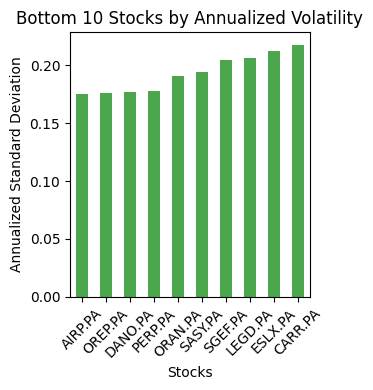

In [ ]:
# 10 stocks with the lowest monthly volatility
bottom_10_monthly = monthly_standard_deviations.sort_values(ascending=True).head(10)

# 10 stocks with the lowest annualized volatility
bottom_10_annualized = annualized_standard_deviations.sort_values(ascending=True).head(10)

# Plotting
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
bottom_10_annualized.plot(kind='bar', color='green', alpha=0.7)
plt.title('Bottom 10 Stocks by Annualized Volatility')
plt.ylabel('Annualized Standard Deviation')
plt.xlabel('Stocks')
plt.xticks(rotation=45)
plt.tight_layout()  # Ensure that titles and labels don't overlap
plt.show()


In [ ]:
# Calculating expected annual returns using ema_historical_return
mu = expected_returns.mean_historical_return(df, returns_data = False, frequency=12,log_returns=True)  # 12 months in a year
Sigma= risk_models.sample_cov(df, returns_data=False, frequency=12, log_returns=True)
risk_free_rate = 0.03119

In [ ]:
# Assuming the portfolio is equally weighted
equal_weights = np.array([1./len(mu) for x in mu])

# Calculate the portfolio return, variance, standard deviation, and Sharpe ratio for equally weighted portfolio
equal_weighted_return = equal_weights.T @ mu
equal_weighted_variance = equal_weights.T @ Sigma @ equal_weights
equal_weighted_stddev = np.sqrt(equal_weighted_variance)
risk_free_rate = 0.03119  # you can set this to the current risk-free rate
equal_weighted_sharpe_ratio = (equal_weighted_return - risk_free_rate) / equal_weighted_stddev

# Efficient Frontier using Mean Variance Optimization
ef = EfficientFrontier(mu, Sigma)

# Optimize to minimize the portfolio's variance
raw_weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

optimized_return = ef.portfolio_performance()[0]
optimized_stddev = ef.portfolio_performance()[1]

optimized_sharpe_ratio = (optimized_return - risk_free_rate) / optimized_stddev

print("Equally Weighted Portfolio:")
print(f"Return: {equal_weighted_return}")
print(f"Variance: {equal_weighted_variance}")
print(f"Standard Deviation: {equal_weighted_stddev}")
print(f"Sharpe Ratio: {equal_weighted_sharpe_ratio}\n")

print("Optimized Portfolio:")
print(f"Return: {optimized_return}")
print(f"Standard Deviation: {optimized_stddev}")
print(f"Sharpe Ratio: {optimized_sharpe_ratio}")

Equally Weighted Portfolio:
Return: 0.035266876859328264
Variance: 0.030331979370721553
Standard Deviation: 0.1741607859729668
Sharpe Ratio: 0.023408695801137903

Optimized Portfolio:
Return: 0.05520821878229663
Standard Deviation: 0.11912032649550328
Sharpe Ratio: 0.20162989381332247


In [ ]:
# Efficient Frontier ESG Scores
eff_frontier_esg_scores = []

# Iterate through the efficient frontier
for i in np.arange(0.01, 0.17, 0.0025):
    ef_mv_target = EfficientFrontier(mu, Sigma)
    ef_mv_target.efficient_return(i)
    weights = ef_mv_target.clean_weights()
    weights_array = np.array(list(weights.values()))
    eff_frontier_esg_score = weights_array.T @ esg_scores
    eff_frontier_esg_scores.append(eff_frontier_esg_score)

# Determine the range of ESG scores on the efficient frontier
min_ef_esg_score = min(eff_frontier_esg_scores)
max_ef_esg_score = max(eff_frontier_esg_scores)

print("ESG Score Range for Classic Efficient Frontier:")
print(f"Minimum ESG Score: {min_ef_esg_score}")
print(f"Maximum ESG Score: {max_ef_esg_score}")


ESG Score Range for Classic Efficient Frontier:
Minimum ESG Score: 13.964935
Maximum ESG Score: 19.037712000000003


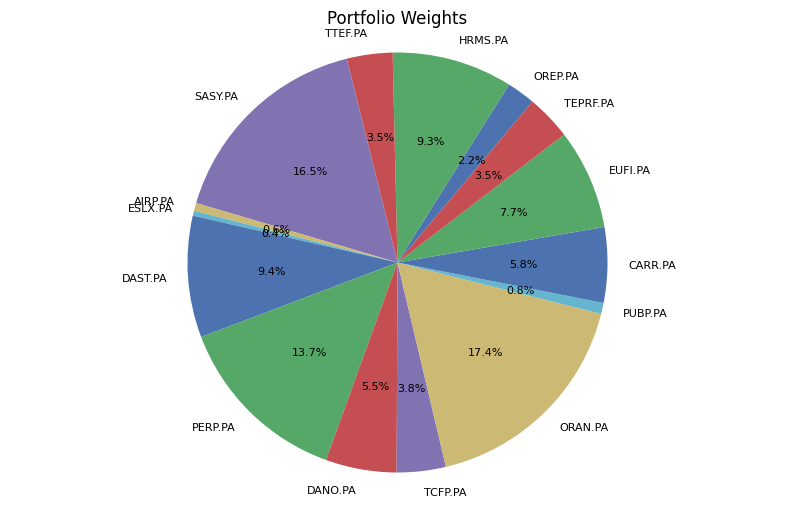

In [ ]:
def plot_weights(weights):
    # Filter out weights that are higher than 0%
    filtered_weights = {k: v for k, v in weights.items() if v > 0}
    labels = filtered_weights.keys()
    sizes = filtered_weights.values()

    fig, ax = plt.subplots(figsize=[10,6])
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=50)

    # Increase the size of the labels and percentages
    for text in texts + autotexts:
        text.set_fontsize(8)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    plt.title('Portfolio Weights')
    plt.show()

ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()

plot_weights(raw_weights_minvar_exp)


In [ ]:
raw_weights_minvar_exp = np.array(list(cleaned_weights.values()))
optimized_esg_score = raw_weights_minvar_exp.T @ esg_scores

print(f"ESG Score: {optimized_esg_score}")

ESG Score: 19.037712000000003


In [ ]:
raw_weights_minvar_exp

OrderedDict([('LVMH.PA', 0.0),
             ('OREP.PA', 0.0219865264516284),
             ('HRMS.PA', 0.0927982287232714),
             ('TTEF.PA', 0.035215885644621),
             ('SASY.PA', 0.165388481647666),
             ('AIR.PA', 0.0),
             ('SCHN.PA', 0.0),
             ('AIRP.PA', 0.0061452706308026),
             ('ESLX.PA', 0.0037848439362546),
             ('BNPP.PA', 0.0),
             ('PRTP.PA', 0.0),
             ('AXAF.PA', 0.0),
             ('SAF.PA', 0.0),
             ('SGEF.PA', 0.0),
             ('STLAM.PA', 0.0),
             ('DAST.PA', 0.0935164247245532),
             ('PERP.PA', 0.1369985431067927),
             ('STMPA.PA', 0.0),
             ('DANO.PA', 0.0546066644224884),
             ('ENGIE.PA', 0.0),
             ('CAGR.PA', 0.0),
             ('SGOB.PA', 0.0),
             ('CAPP.PA', 0.0),
             ('TCFP.PA', 0.03772827201368),
             ('ORAN.PA', 0.1736007031831566),
             ('LEGD.PA', 0.0),
             ('MT.AS', 0.0),
   

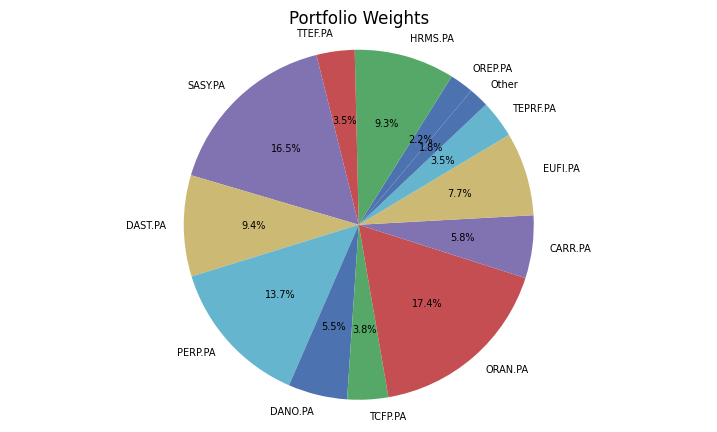

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier

def plot_weights(weights, threshold=0.02):
    # Filter out weights that are higher than 0%
    filtered_weights = {k: v for k, v in weights.items() if v > 0}

    # Group small weights into an 'Other' category
    other_weight = sum(w for k, w in filtered_weights.items() if w <= threshold)

    if other_weight > 0:
        # Remove individual items that are grouped into 'Other'
        for k in list(filtered_weights.keys()):
            if filtered_weights[k] <= threshold:
                del filtered_weights[k]

        filtered_weights["Other"] = other_weight

    labels = filtered_weights.keys()
    sizes = filtered_weights.values()

    fig, ax = plt.subplots(figsize=[9,5])  # Increase the figure size
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=50)

    # Increase the size of the labels and percentages
    for text in texts + autotexts:
        text.set_fontsize(7)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    plt.title('Portfolio Weights')
    plt.show()

ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()

plot_weights(raw_weights_minvar_exp)


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# Specific return level
target_return = 0.15

# Create the efficient frontier object
ef_mv_target = EfficientFrontier(mu, Sigma)

# Target the specific return level and minimize variance
ef_mv_target.efficient_return(target_return)

# Portfolio performance
min_var_return, min_var_stddev, min_var_sharpe = ef_mv_target.portfolio_performance(verbose = True)
print("Minimum Variance Portfolio at 15% Return:")
print(f"Return: {min_var_return:.2%}, Standard Deviation: {min_var_stddev:.2%}, Sharpe Ratio: {min_var_sharpe}")

Expected annual return: 15.0%
Annual volatility: 15.6%
Sharpe Ratio: 0.83
Minimum Variance Portfolio at 15% Return:
Return: 15.00%, Standard Deviation: 15.58%, Sharpe Ratio: 0.8343044371312989


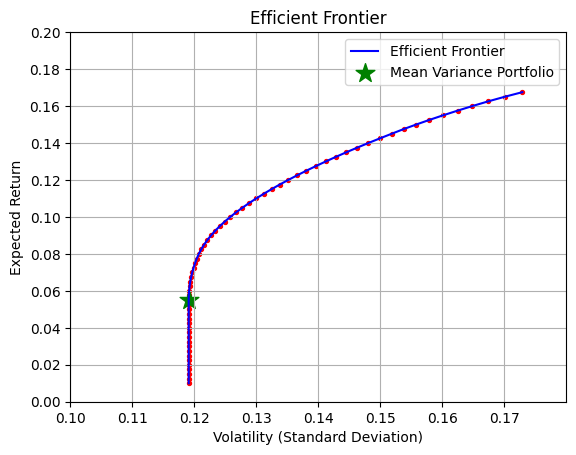

In [ ]:
## Iterations for efficient frontier pairs
ret_ef = np.arange(0.01, 0.17, 0.0025)
vol_ef = []
for i in np.arange(0.01, 0.17, 0.0025):
    ef_mv_target = EfficientFrontier(mu, Sigma)
    ef_mv_target.efficient_return(i)
    vol_ef.append(ef_mv_target.portfolio_performance()[1])

# Plot Efficient Frontier
plt.plot(vol_ef, ret_ef, label="Efficient Frontier", color='blue')

# Plot the individual points on the Efficient Frontier
plt.scatter(vol_ef, ret_ef, color='red', marker='o', s=8)

# Plot the point for the Mean Variance Portfolio
plt.scatter(optimized_stddev, optimized_return, color='green', marker='*', s=200, label='Mean Variance Portfolio')

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.legend()

# Adjust the x-axis and y-axis limits to zoom in
plt.xlim(0.10, 0.18)  # Adjusted the x-axis limits to be closely around the range [0.11, 0.15]
plt.ylim(0, 0.16)  # Adjusted the y-axis limits to range from 0 to 0.14

# Set custom ticks for the x-axis and y-axis
plt.xticks(np.arange(0.10, 0.18, 0.01))  # Ticks from 0.10 to 0.16 with step of 0.01
plt.yticks(np.arange(0, 0.2+0.01, 0.02))  # Ticks from 0 to 0.14 with step of 0.02

plt.grid(True)  # This adds a grid for better readability
plt.show()


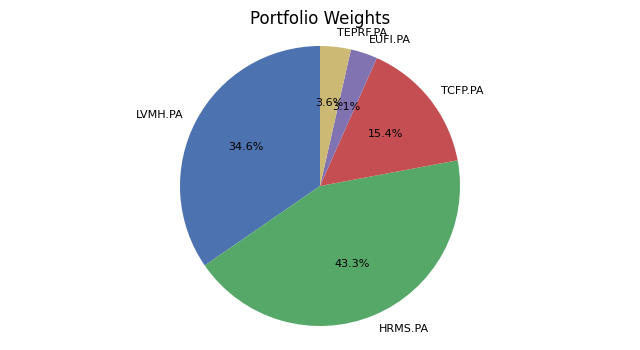

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# Specific return level
target_return = 0.17

# Create the efficient frontier object
ef_mv_target = EfficientFrontier(mu, Sigma)

# Target the specific return level and minimize variance
ef_mv_target.efficient_return(target_return)

# Get the portfolio weights
raw_weights_mv_target = ef_mv_target.clean_weights()

# Function to plot the weights in a pie chart
def plot_weights(weights):
    # Filter out weights that are higher than 0%
    filtered_weights = {k: v for k, v in weights.items() if v > 0}
    labels = filtered_weights.keys()
    sizes = filtered_weights.values()

    fig, ax = plt.subplots(figsize=[8,4])
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

    # Increase the size of the labels and percentages
    for text in texts + autotexts:
        text.set_fontsize(8)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')

    plt.title('Portfolio Weights')
    plt.show()

# Plot the weights
plot_weights(raw_weights_mv_target)

In [ ]:
raw_weights_mv_target

OrderedDict([('LVMH.PA', 0.34612),
             ('OREP.PA', 0.0),
             ('HRMS.PA', 0.4333),
             ('TTEF.PA', 0.0),
             ('SASY.PA', 0.0),
             ('AIR.PA', 0.0),
             ('SCHN.PA', 0.0),
             ('AIRP.PA', 0.0),
             ('ESLX.PA', 0.0),
             ('BNPP.PA', 0.0),
             ('PRTP.PA', 0.0),
             ('AXAF.PA', 0.0),
             ('SAF.PA', 0.0),
             ('SGEF.PA', 0.0),
             ('STLAM.PA', 0.0),
             ('DAST.PA', 0.0),
             ('PERP.PA', 0.0),
             ('STMPA.PA', 0.0),
             ('DANO.PA', 0.0),
             ('ENGIE.PA', 0.0),
             ('CAGR.PA', 0.0),
             ('SGOB.PA', 0.0),
             ('CAPP.PA', 0.0),
             ('TCFP.PA', 0.15403),
             ('ORAN.PA', 0.0),
             ('LEGD.PA', 0.0),
             ('MT.AS', 0.0),
             ('MICP.PA', 0.0),
             ('VIE.PA', 0.0),
             ('SOGN.PA', 0.0),
             ('PUBP.PA', 0.0),
             ('EDEN.PA', 0.0),

In [ ]:
risk_free_rate = 0.0311  # Assume 3% as an example

ef_for_sharpe = EfficientFrontier(mu, Sigma)
ef_for_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
tangent_return, tangent_stddev, tangent_sharpe = ef_for_sharpe.portfolio_performance(risk_free_rate=risk_free_rate)

In [ ]:
tangent_return, tangent_stddev, tangent_sharpe

(0.17104309266681628, 0.17725475425327697, 0.7895026187385273)

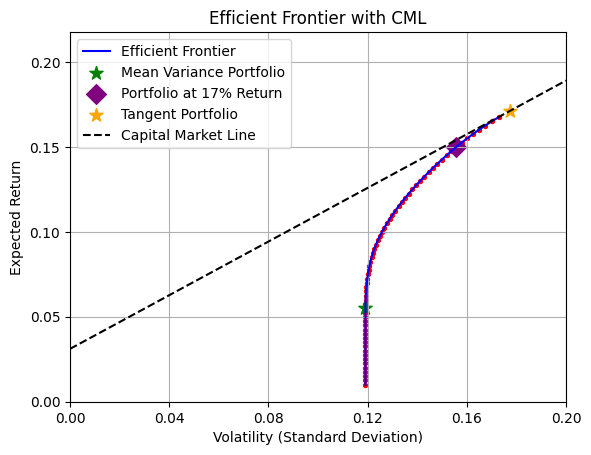

In [ ]:
# Plot Efficient Frontier
plt.plot(vol_ef, ret_ef, label="Efficient Frontier", color='blue')

# Plot the individual points on the Efficient Frontier
plt.scatter(vol_ef, ret_ef, color='red', marker='o', s=8)  # s=50 sets the size of the points

# Plot the point for the Mean Variance Portfolio
plt.scatter(optimized_stddev, optimized_return, color='green', marker='*', s=100, label='Mean Variance Portfolio')

# Plot the point for the Portfolio optimized for 17% Return
plt.scatter(min_var_stddev, min_var_return, color='purple', marker='D', s=100, label='Portfolio at 17% Return')

# Plot the Tangent Portfolio
plt.scatter(tangent_stddev, tangent_return, color='orange', marker='*', s=100, label='Tangent Portfolio')

# Plot the Capital Market Line (CML)
x = np.linspace(0, 0.2, 100)  # Extended the range to 1.5 times the tangent portfolio's volatility
y = risk_free_rate + (tangent_return - risk_free_rate) / tangent_stddev * x
plt.plot(x, y, linestyle='--', color='black', label='Capital Market Line')

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier with CML")

# Adjust the x-axis and y-axis limits
plt.xlim(0, 0.20)  # Adjusted the x-axis limits to be between 0.1 and 0.2
# Adjust the y-axis as per your needs
plt.ylim(min(ret_ef), max(ret_ef) + 0.05)

# Set custom ticks for the x-axis and y-axis
plt.xticks(np.arange(0, 0.20+0.02, 0.04))  # Ticks from 0 to 0.2 with step of 0.025
plt.yticks(np.arange(0, max(ret_ef) + 0.05, 0.05))  # Modify step size as required, e.g., every 0.05
plt.legend()
plt.grid(True)  # This adds a grid for better readability
plt.show()

## **Second Part**

In [ ]:
# Assuming you've copied the data into a CSV file
esg_df=pd.read_excel('ESG scores CAC40.xlsx')

# You can then turn the ESG scores into a dictionary with the tickers as keys:
esg_scores = dict(zip(esg_df['Tickers'], esg_df[' ESG Risk rating']))


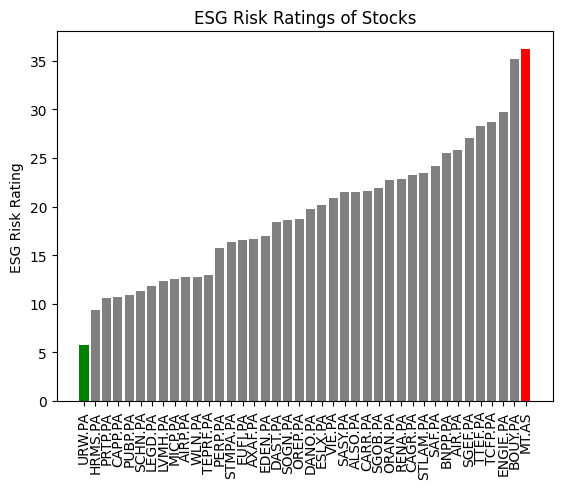

In [ ]:
import matplotlib.pyplot as plt

# Sort the ESG scores
sorted_esg = sorted(esg_scores.items(), key=lambda x: x[1])

# Separate keys and values
keys = [x[0] for x in sorted_esg]
values = [x[1] for x in sorted_esg]

# Set colors to highlight the highest and lowest scores
colors = ['grey'] * len(values)
colors[0] = 'green' # Color for the lowest value
colors[-1] = 'red' # Color for the highest value

plt.bar(keys, values, color=colors)
plt.xticks(rotation=90) # Rotate x labels for better visibility
plt.ylabel('ESG Risk Rating')
plt.title('ESG Risk Ratings of Stocks')
plt.show()


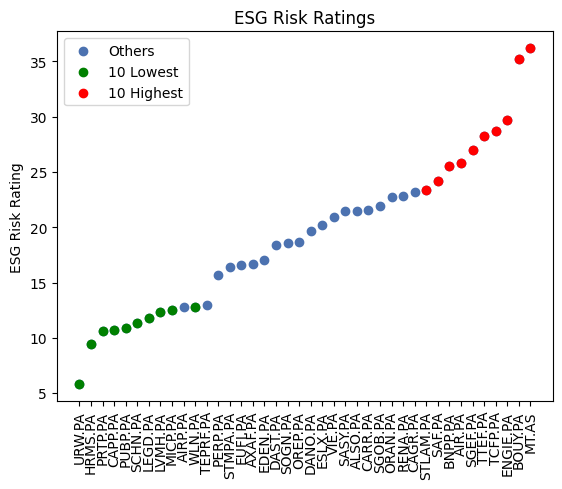

In [ ]:
import numpy as np

# Create labels and values for all the data
labels_all = [x[0] for x in sorted_esg]
values_all = [x[1] for x in sorted_esg]

# Identify indexes of 10 lowest and 10 highest
lowest_idx = np.argsort(values_all)[:10]
highest_idx = np.argsort(values_all)[-10:]

plt.scatter(labels_all, values_all, label='Others')
plt.scatter(np.array(labels_all)[lowest_idx], np.array(values_all)[lowest_idx], color='green', label='10 Lowest')
plt.scatter(np.array(labels_all)[highest_idx], np.array(values_all)[highest_idx], color='red', label='10 Highest')

plt.xticks(rotation=90) # Rotate x labels for better visibility
plt.ylabel('ESG Risk Rating')
plt.title('ESG Risk Ratings')
plt.legend()
plt.show()


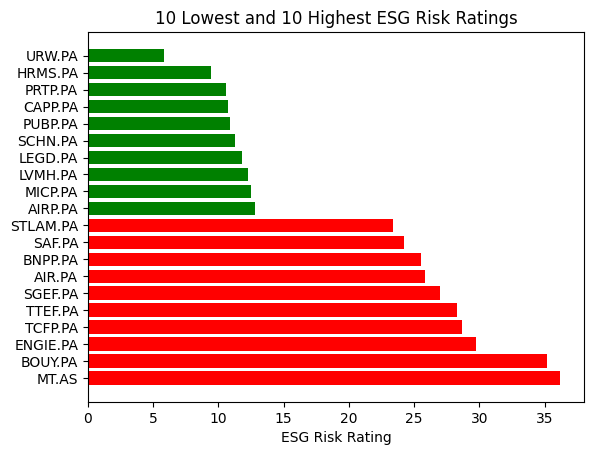

In [ ]:
import matplotlib.pyplot as plt

# Separate the 10 lowest and 10 highest
lowest_10 = sorted_esg[:10]
highest_10 = sorted_esg[-10:]

# Create labels and values for the bar chart
labels = [x[0] for x in lowest_10 + highest_10]
values = [x[1] for x in lowest_10 + highest_10]

# Use different colors for the lowest and highest
colors = ['green']*10 + ['red']*10

plt.barh(labels, values, color=colors)
plt.xlabel('ESG Risk Rating')
plt.title('10 Lowest and 10 Highest ESG Risk Ratings')
plt.gca().invert_yaxis() # Invert y-axis to have higher scores on top
plt.show()


In [ ]:
# Convert ESG scores to a pandas Series
esg_series = pd.Series(esg_scores, name='ESG Score')

# Combine mu (expected returns) and ESG scores into a DataFrame
combined_data = pd.DataFrame({
    'Expected Returns': mu,
    'ESG Score': esg_series
})

# Make sure to align by the index (stock tickers)
combined_data = combined_data.dropna()

# Now you can access the combined data
print(combined_data)


          Expected Returns  ESG Score
LVMH.PA           0.183026       12.3
OREP.PA           0.109594       18.7
HRMS.PA           0.193834        9.4
TTEF.PA          -0.002704       28.3
SASY.PA           0.009368       21.5
AIR.PA            0.041231       25.8
SCHN.PA           0.080751       11.3
AIRP.PA           0.075650       12.8
ESLX.PA           0.056994       20.2
BNPP.PA          -0.038889       25.5
PRTP.PA           0.083946       10.6
AXAF.PA           0.011975       16.7
SAF.PA            0.086979       24.2
SGEF.PA           0.079979       27.0
STLAM.PA          0.078628       23.4
DAST.PA           0.118408       18.4
PERP.PA           0.067904       15.7
STMPA.PA          0.155086       16.4
DANO.PA          -0.016449       19.7
ENGIE.PA         -0.047396       29.7
CAGR.PA          -0.024251       23.2
SGOB.PA           0.014992       21.9
CAPP.PA           0.114774       10.7
TCFP.PA           0.105390       28.7
ORAN.PA           0.007857       22.7
LEGD.PA     

In [ ]:
# Calculate the Mean (Average) ESG Score
mean_esg_score = combined_data['ESG Score'].mean()
print('Mean ESG Score:', mean_esg_score)

# Calculate the Median ESG Score
median_esg_score = combined_data['ESG Score'].median()
print('Median ESG Score:', median_esg_score)

# Calculate the Standard Deviation of ESG Score
std_esg_score = combined_data['ESG Score'].std()
print('Standard Deviation of ESG Score:', std_esg_score)

# Find the Minimum and Maximum ESG Score
min_esg_score = combined_data['ESG Score'].min()
max_esg_score = combined_data['ESG Score'].max()
print('Minimum ESG Score:', min_esg_score)
print('Maximum ESG Score:', max_esg_score)

# Calculate the Quantiles (25th, 50th, and 75th percentiles) of ESG Score
quantiles = combined_data['ESG Score'].quantile([0.25, 0.5, 0.75])
print('Quantiles of ESG Score:\n', quantiles)

# Calculate the Skewness of ESG Score
skewness = combined_data['ESG Score'].skew()
print('Skewness of ESG Score:', skewness)

# Calculate the Kurtosis of ESG Score
kurtosis = combined_data['ESG Score'].kurt()
print('Kurtosis of ESG Score:', kurtosis)

# Calculate the Correlation between ESG Score and Expected Returns
correlation = combined_data['ESG Score'].corr(combined_data['Expected Returns'])
print('Correlation between ESG Score and Expected Returns:', correlation)

Mean ESG Score: 19.3
Median ESG Score: 19.2
Standard Deviation of ESG Score: 7.059345506090417
Minimum ESG Score: 5.8
Maximum ESG Score: 36.2
Quantiles of ESG Score:
 0.25    12.80
0.50    19.20
0.75    23.25
Name: ESG Score, dtype: float64
Skewness of ESG Score: 0.38776075347954064
Kurtosis of ESG Score: -0.1606379147220669
Correlation between ESG Score and Expected Returns: -0.2646089405690433


In [ ]:
import pandas as pd

# Assuming 'combined_data' DataFrame has already been created
# as per your previous code snippet

# Calculate various statistical measures
mean_esg_score = combined_data['ESG Score'].mean()
median_esg_score = combined_data['ESG Score'].median()
std_esg_score = combined_data['ESG Score'].std()
min_esg_score = combined_data['ESG Score'].min()
max_esg_score = combined_data['ESG Score'].max()
quantiles = combined_data['ESG Score'].quantile([0.25, 0.5, 0.75])
skewness = combined_data['ESG Score'].skew()
kurtosis = combined_data['ESG Score'].kurt()
correlation = combined_data['ESG Score'].corr(combined_data['Expected Returns'])

# Create a DataFrame to hold the metrics
metrics_data = {
    'Metric': [
        'Mean ESG Score',
        'Median ESG Score',
        'Standard Deviation of ESG Score',
        'Minimum ESG Score',
        'Maximum ESG Score',
        '25th Percentile',
        '50th Percentile',
        '75th Percentile',
        'Skewness of ESG Score',
        'Kurtosis of ESG Score',
        'Correlation between ESG Score and Expected Returns'
    ],
    'Value': [
        mean_esg_score,
        median_esg_score,
        std_esg_score,
        min_esg_score,
        max_esg_score,
        quantiles[0.25],
        quantiles[0.5],
        quantiles[0.75],
        skewness,
        kurtosis,
        correlation
    ]
}

metrics_table = pd.DataFrame(metrics_data)

# Print the metrics table
print(metrics_table)


                                               Metric      Value
0                                      Mean ESG Score  19.300000
1                                    Median ESG Score  19.200000
2                     Standard Deviation of ESG Score   7.059346
3                                   Minimum ESG Score   5.800000
4                                   Maximum ESG Score  36.200000
5                                     25th Percentile  12.800000
6                                     50th Percentile  19.200000
7                                     75th Percentile  23.250000
8                               Skewness of ESG Score   0.387761
9                               Kurtosis of ESG Score  -0.160638
10  Correlation between ESG Score and Expected Ret...  -0.264609


In [ ]:
###INITIAL PORTFOLIO RETURN

# 1. Set Initial Weights
num_stocks = len(combined_data)
initial_weights = np.array([1/num_stocks] * num_stocks)

# 2. Compute Average ESG Risk Rating
portfolio_esg_rating = np.dot(initial_weights, combined_data['ESG Score'])

# 3. Calculate Portfolio Return
portfolio_return = np.dot(initial_weights, combined_data['Expected Returns'])

# 4. Calculate Portfolio Variance and Standard Deviation
portfolio_variance = np.dot(initial_weights.T, np.dot(Sigma, initial_weights))
portfolio_std_dev = np.sqrt(portfolio_variance)

# 5. Calculate the Sharpe Ratio
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

print(f'Portfolio ESG Rating: {portfolio_esg_rating}')
print(f'Portfolio Return: {portfolio_return}')
print(f'Portfolio Variance: {portfolio_variance}')
print(f'Portfolio Std Dev: {portfolio_std_dev}')
print(f'Sharpe Ratio: {sharpe_ratio}')


Portfolio ESG Rating: 19.3
Portfolio Return: 0.035266876859328264
Portfolio Variance: 0.030331979370721553
Portfolio Std Dev: 0.1741607859729668
Sharpe Ratio: 0.023925459661022927


In [ ]:
## maximizing sharpe ration
from pypfopt import objective_functions

# Ensure data alignment for optimization
aligned_mu = combined_data['Expected Returns']
aligned_cov_matrix = Sigma.loc[aligned_mu.index, aligned_mu.index]

# Construct the Efficient Frontier Object
ef = EfficientFrontier(aligned_mu, aligned_cov_matrix)

# Set constraints (the default bounds of 0 to 1 enforce no-leverage)
ef.add_objective(objective_functions.L2_reg, gamma=0)  # Enforce closeness to the initial weights if desired

# Maximize the Sharpe Ratio
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)

# Get the expected return, volatility, and Sharpe ratio for the optimized portfolio
optimized_return, optimized_stddev, optimized_sharpe = ef.portfolio_performance(risk_free_rate=risk_free_rate)

# Given the optimized weights are in 'weights_optimized' dictionary
optimized_weights_array = np.array([weights[ticker] for ticker in combined_data.index])

# Compute Average ESG Risk Rating for the Optimized Portfolio
portfolio_esg_rating_optimized = np.dot(optimized_weights_array, combined_data['ESG Score'])

print(f"Expected Portfolio Return: {optimized_return}")
print(f"Expected Portfolio Volatility: {optimized_stddev}")
print(f"Average ESG Risk Rating for the Optimized Portfolio: {portfolio_esg_rating_optimized:.2f}")
print(f"Portfolio Sharpe Ratio: {optimized_sharpe}")


Expected Portfolio Return: 0.17104309266681628
Expected Portfolio Volatility: 0.17725475425327697
Average ESG Risk Rating for the Optimized Portfolio: 13.63
Portfolio Sharpe Ratio: 0.7895026187385273


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


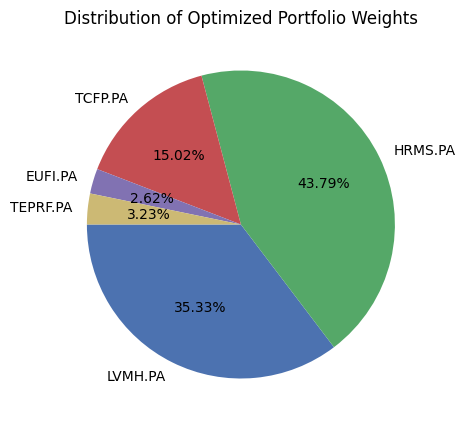

In [ ]:
import matplotlib.pyplot as plt

# Filter out stocks with weights greater than 0
filtered_weights = {ticker: weight for ticker, weight in weights.items() if weight > 0}

# Extract tickers and their corresponding weights
tickers = list(filtered_weights.keys())
values = list(filtered_weights.values())

# Create a pie chart
plt.figure(figsize=(6, 5))
plt.pie(values, labels=tickers, autopct='%1.2f%%', startangle=180)
plt.title('Distribution of Optimized Portfolio Weights')

plt.show()


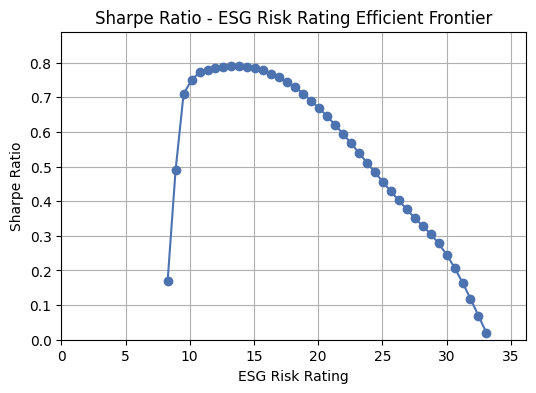

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

init_guess = [1.0/len(aligned_mu) for _ in aligned_mu]

# Define the Sharpe ratio objective
def sharpe_ratio_objective(weights, mu, Sigma, risk_free_rate=0.0311):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# Define the minimum Sharpe ratio constraint
def min_sharpe_constraint(weights, mu, Sigma, risk_free_rate=0.0311, min_sharpe=0.01):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return sharpe - min_sharpe  # this should be >= 0 to satisfy the constraint

min_sharpe_cons = {'type': 'ineq', 'fun': min_sharpe_constraint, 'args': (aligned_mu, aligned_cov_matrix, risk_free_rate, 0.01)}

# Define the ESG score constraint
def esg_constraint(weights, target_esg, esg_scores):
    return np.dot(weights, esg_scores) - target_esg

# Define the weight sum constraint
def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# Set up the constraints
weight_constraint = {'type': 'eq', 'fun': weight_sum_constraint}
bounds = [(0, 1) for _ in aligned_mu]

# Set the ESG score range
esg_scores = combined_data['ESG Score']
min_esg, max_esg = esg_scores.min(), esg_scores.max()
target_esgs = np.linspace(min_esg, max_esg, 50)

sharpe_ratios = []

for target_esg in target_esgs:
    esg_cons = {'type': 'eq', 'fun': esg_constraint, 'args': [target_esg, esg_scores]}
    result = minimize(
        sharpe_ratio_objective,
        init_guess,
        args=(aligned_mu, aligned_cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=[weight_constraint, esg_cons, min_sharpe_cons]
    )
    if -result.fun >= 0.01:  # Only append if the Sharpe ratio is >= 0.01
        sharpe_ratios.append(-result.fun)
    else:
        sharpe_ratios.append(None)  # Append None, so the list lengths remain consistent, but this point won't be plotted.

# Plotting the Sharpe Ratio - ESG Risk Rating Efficient Frontier
plt.figure(figsize=(6, 4))  # Optional: You can set a figure size for better visualization
plt.plot(target_esgs, sharpe_ratios, '-o')
plt.xlabel("ESG Risk Rating")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio - ESG Risk Rating Efficient Frontier")
plt.grid(True)

plt.xlim(0, max(target_esgs))
plt.ylim(0, max((val for val in sharpe_ratios if val is not None)) + 0.1)


plt.show()


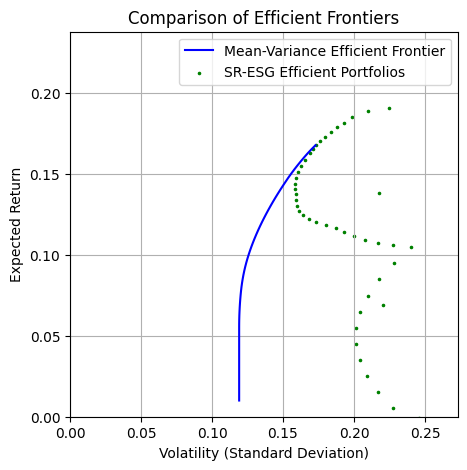

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pypfopt.efficient_frontier import EfficientFrontier


# Iterations for efficient frontier pairs
ret_ef = np.arange(0.01, 0.17, 0.0025)
vol_ef = []
for i in np.arange(0.01, 0.17, 0.0025):
    ef_mv_target = EfficientFrontier(mu, Sigma)
    ef_mv_target.efficient_return(i)
    vol_ef.append(ef_mv_target.portfolio_performance()[1])

# Sharpe Ratio - ESG Optimization Model
init_guess = [1.0/len(aligned_mu) for _ in aligned_mu]

def sharpe_ratio_objective(weights, mu, Sigma, risk_free_rate=0.0311):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# Optimization settings
bounds = [(0, 1) for _ in aligned_mu]
weight_constraint = {'type': 'eq', 'fun': weight_sum_constraint}
min_esg, max_esg = esg_scores.min(), esg_scores.max()
target_esgs = np.linspace(min_esg, max_esg, 50)

# Lists to store results for the ESG Risk Rating Model
expected_returns_esg = []
volatility_esg = []

for target_esg in target_esgs:
    esg_cons = {'type': 'eq', 'fun': lambda weights: np.dot(weights, esg_scores) - target_esg}
    result = minimize(
        sharpe_ratio_objective,
        init_guess,
        args=(aligned_mu, aligned_cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=[weight_constraint, esg_cons]
    )

    if result.success:
        portfolio_return = np.dot(result.x, aligned_mu)
        portfolio_volatility = np.sqrt(np.dot(result.x.T, np.dot(aligned_cov_matrix, result.x)))
        expected_returns_esg.append(portfolio_return)
        volatility_esg.append(portfolio_volatility)

# Plotting the Efficient Frontiers
plt.figure(figsize=(5,5 ))

# Plot Mean-Variance Efficient Frontier
plt.plot(vol_ef, ret_ef, label="Mean-Variance Efficient Frontier", color='blue')

# Plot Sharpe Ratio - ESG Risk Rating Efficient Portfolios on the Mean-Variance Frontier
plt.scatter(volatility_esg, expected_returns_esg, color='green', marker='.', s=10, label="SR-ESG Efficient Portfolios")

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Comparison of Efficient Frontiers")
plt.legend()


plt.xlim(0, max(vol_ef) + 0.1)
plt.ylim(0, max((ret_ef)) + 0.07)

plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the 6% return constraint
target_return = 0.06  # 6% return
def return_constraint(weights, target_return, mu):
    portfolio_return = np.dot(weights, mu)
    return portfolio_return - target_return

# Define the ESG score constraint
def esg_constraint(weights, target_esg, esg_scores):
    return np.dot(weights, esg_scores) - target_esg

# Define the weight sum constraint
def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# Set up the constraints
weight_constraint = {'type': 'eq', 'fun': weight_sum_constraint}
return_constraint = {'type': 'eq', 'fun': return_constraint, 'args': [target_return, aligned_mu]}
bounds = [(0, 1) for _ in aligned_mu]

# Set the ESG score range
esg_scores = combined_data['ESG Score']
min_esg, max_esg = esg_scores.min(), esg_scores.max()
target_esgs = np.linspace(min_esg, max_esg, 50)

for target_esg in target_esgs:
    esg_cons = {'type': 'eq', 'fun': esg_constraint, 'args': [target_esg, esg_scores]}
    result = minimize(
        sharpe_ratio_objective,
        init_guess,
        args=(aligned_mu, aligned_cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=[weight_constraint, esg_cons, return_constraint]
    )
    if result.success:  # Only append if the optimization was successful
        portfolio_weights = result.x
        portfolio_return = np.dot(portfolio_weights, aligned_mu)
        portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(aligned_cov_matrix, portfolio_weights)))
        portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
        portfolio_esg = np.dot(portfolio_weights, esg_scores)

        print(f'For target ESG of {target_esg:.2f}:')
        print(f'\tPortfolio Return: {portfolio_return*100:.2f}%')
        print(f'\tPortfolio Standard Deviation: {portfolio_volatility*100:.2f}%')
        print(f'\tPortfolio ESG Risk Rating: {portfolio_esg:.2f}')
        print(f'\tPortfolio Sharpe Ratio: {portfolio_sharpe:.4f}')
        print('---------------------------------------')


For target ESG of 8.28:
	Portfolio Return: 6.00%
	Portfolio Standard Deviation: 21.97%
	Portfolio ESG Risk Rating: 8.28
	Portfolio Sharpe Ratio: 0.1315
---------------------------------------
For target ESG of 8.90:
	Portfolio Return: 6.00%
	Portfolio Standard Deviation: 20.28%
	Portfolio ESG Risk Rating: 8.90
	Portfolio Sharpe Ratio: 0.1425
---------------------------------------
For target ESG of 9.52:
	Portfolio Return: 6.00%
	Portfolio Standard Deviation: 18.80%
	Portfolio ESG Risk Rating: 9.52
	Portfolio Sharpe Ratio: 0.1537
---------------------------------------
For target ESG of 10.14:
	Portfolio Return: 6.00%
	Portfolio Standard Deviation: 17.56%
	Portfolio ESG Risk Rating: 10.14
	Portfolio Sharpe Ratio: 0.1646
---------------------------------------
For target ESG of 10.76:
	Portfolio Return: 6.00%
	Portfolio Standard Deviation: 16.60%
	Portfolio ESG Risk Rating: 10.76
	Portfolio Sharpe Ratio: 0.1741
---------------------------------------
For target ESG of 11.38:
	Portfolio 

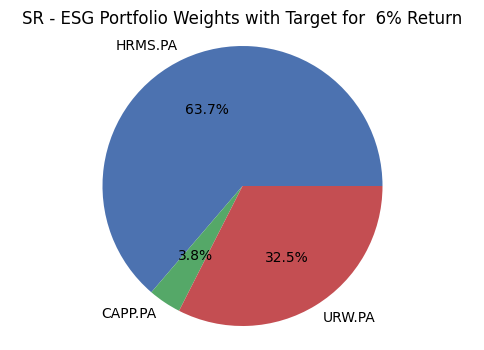

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ... Your previous data loading and preparation steps ...

# Your target ESG score and return rate
target_esg = 8.28
target_return = 0.06

# Optimization function (negative Sharpe Ratio)
def sharpe_ratio_objective(weights, mu, Sigma, risk_free_rate=0.0311):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# Constraints
def esg_constraint(weights):
    return np.dot(weights, esg_scores) - target_esg

def return_constraint(weights):
    return np.dot(weights, aligned_mu) - target_return

def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# Set up the constraints and bounds
weight_constraint = {'type': 'eq', 'fun': weight_sum_constraint}
esg_cons = {'type': 'eq', 'fun': esg_constraint}
return_cons = {'type': 'eq', 'fun': return_constraint}
bounds = [(0, 1) for _ in aligned_mu]

# Run the optimizer
result = minimize(
    sharpe_ratio_objective,
    init_guess,
    args=(aligned_mu, aligned_cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=[weight_constraint, esg_cons, return_cons]
)

# Get the optimized weights
optimized_weights = result.x

# Filter out the assets with zero weights
cleaned_weights = [w for w in optimized_weights if w > 1e-6]
cleaned_asset_names = [asset for asset, w in zip(asset_names, optimized_weights) if w > 1e-6]

# Plot the cleaned weights as a pie chart
plt.figure(figsize=(6, 4))
plt.pie(cleaned_weights, labels=cleaned_asset_names, autopct='%1.1f%%')
plt.title('SR - ESG Portfolio Weights with Target for  6% Return')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
